<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9357 entries, 0 to 9356
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date           9357 non-null   datetime64[ns]
 1   Time           9357 non-null   object        
 2   CO(GT)         9357 non-null   float64       
 3   PT08.S1(CO)    9357 non-null   float64       
 4   NMHC(GT)       9357 non-null   int64         
 5   C6H6(GT)       9357 non-null   float64       
 6   PT08.S2(NMHC)  9357 non-null   float64       
 7   NOx(GT)        9357 non-null   float64       
 8   PT08.S3(NOx)   9357 non-null   float64       
 9   NO2(GT)        9357 non-null   float64       
 10  PT08.S4(NO2)   9357 non-null   float64       
 11  PT08.S5(O3)    9357 non-null   float64       
 12  T              9357 non-null   float64       
 13  RH             9357 non-null   float64       
 14  AH             9357 non-null   float64       
dtypes: datetime64[ns](1),

C:\Users\bo.chen18\AppData\Local\Temp\ipykernel_19128\1918804264.py:17: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')


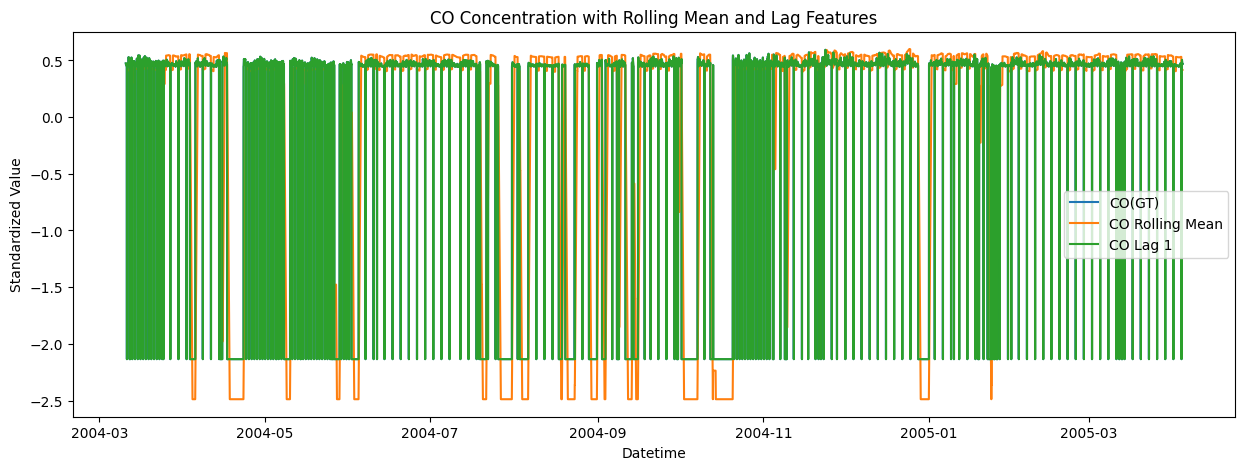

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# 读取数据
file_path = r'D:\Pythonworkshop\Dataset\AirQualityUCI.xlsx'
df = pd.read_excel(file_path)

# 初步数据探索
print(df.info())
print(df.head())

from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# 处理缺失值（前向填充）
df = df.fillna(method='ffill')

# 时间特征提取
df['Datetime'] = pd.to_datetime(df['Date'].astype(str) + ' ' + df['Time'].astype(str))
df['Year'] = df['Datetime'].dt.year
df['Month'] = df['Datetime'].dt.month
df['Day'] = df['Datetime'].dt.day
df['Hour'] = df['Datetime'].dt.hour
df['Weekday'] = df['Datetime'].dt.weekday

# 滚动窗口特征
df['CO_rolling_mean'] = df['CO(GT)'].rolling(window=24).mean()
df['NOx_rolling_mean'] = df['NOx(GT)'].rolling(window=24).mean()

# 滞后特征
df['CO_lag_1'] = df['CO(GT)'].shift(1)
df['NOx_lag_1'] = df['NOx(GT)'].shift(1)

# 标准化
scaler = StandardScaler()
df[['CO(GT)', 'NOx(GT)', 'CO_rolling_mean', 'NOx_rolling_mean', 'CO_lag_1', 'NOx_lag_1']] = scaler.fit_transform(df[['CO(GT)', 'NOx(GT)', 'CO_rolling_mean', 'NOx_rolling_mean', 'CO_lag_1', 'NOx_lag_1']])

# 可视化展示
plt.figure(figsize=(15, 5))
plt.plot(df['Datetime'], df['CO(GT)'], label='CO(GT)')
plt.plot(df['Datetime'], df['CO_rolling_mean'], label='CO Rolling Mean')
plt.plot(df['Datetime'], df['CO_lag_1'], label='CO Lag 1')
plt.legend()
plt.title('CO Concentration with Rolling Mean and Lag Features')
plt.xlabel('Datetime')
plt.ylabel('Standardized Value')
plt.show()


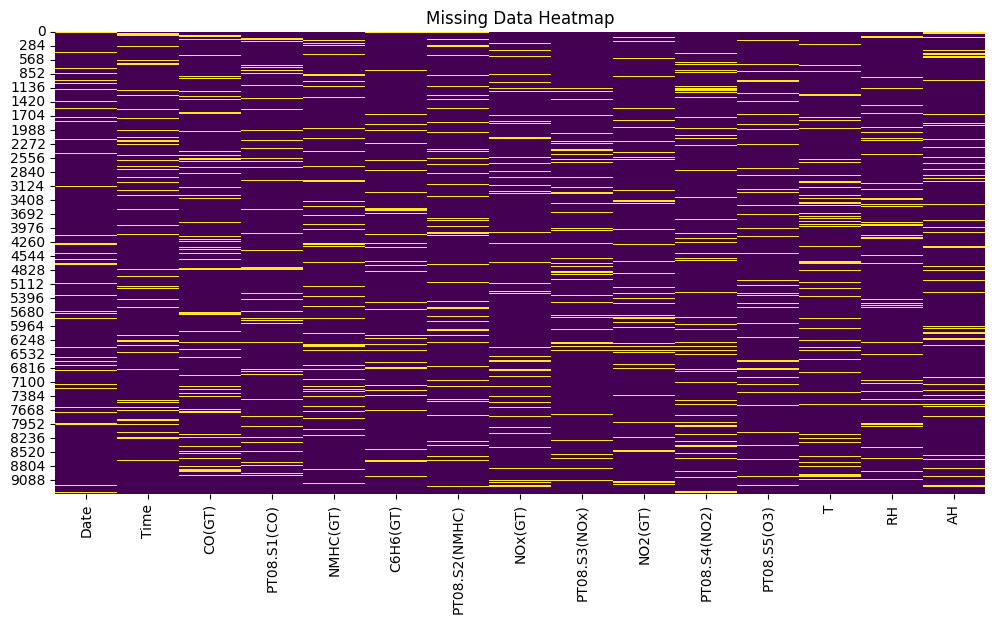

In [11]:
import numpy as np
import seaborn as sns
# 重新读取数据（不删除列）
df = pd.read_excel(file_path)

# 随机删除一些值来制造缺失值
np.random.seed(42)
missing_rate = 0.1
missing_entries = np.random.rand(*df.shape) < missing_rate
df[missing_entries] = np.nan

# 缺失值可视化
plt.figure(figsize=(12, 6))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Data Heatmap')
plt.show()


C:\Users\bo.chen18\AppData\Local\Temp\ipykernel_19128\1168835575.py:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_filled = df.fillna(method='ffill').fillna(method='bfill')


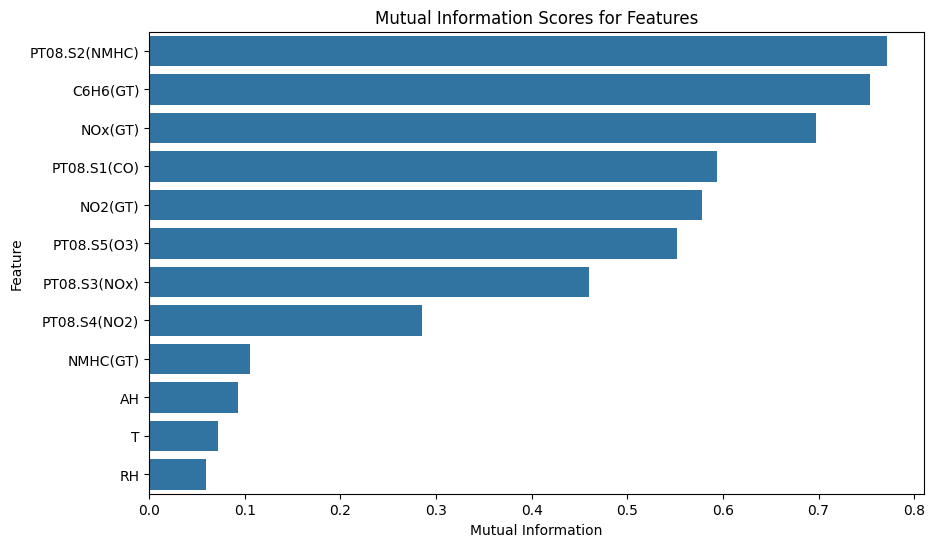

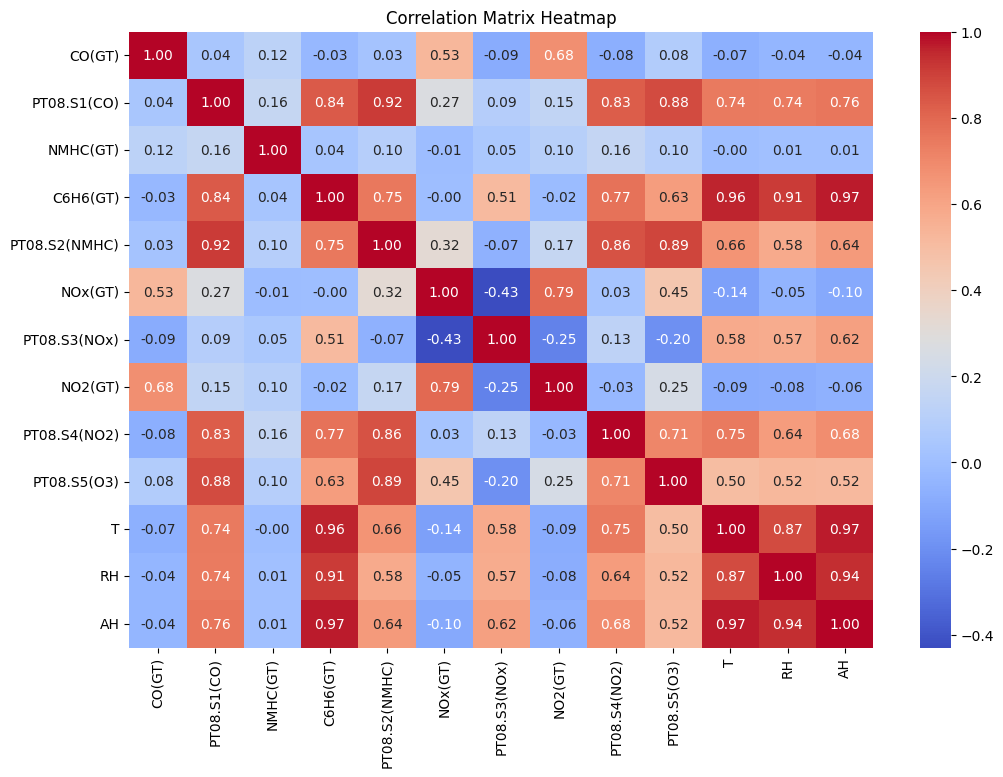

In [14]:
from sklearn.feature_selection import mutual_info_regression
# 再次处理缺失值，确保没有NaN值
df_filled = df.fillna(method='ffill').fillna(method='bfill')

# 确保所有列都没有缺失值
assert df_filled.isnull().sum().sum() == 0, "There are still missing values in the dataset."

# 排除非数值型数据列，重新选择数值型特征
df_filled = df_filled.select_dtypes(include=[np.number])

# 提取数值型特征和目标列进行互信息分析
numerical_features = df_filled.columns.tolist()
numerical_features.remove('CO(GT)')

X = df_filled[numerical_features]
y = df_filled['CO(GT)']

# 计算互信息
mi_scores = mutual_info_regression(X, y)

# 将互信息结果转换为DataFrame
mi_df = pd.DataFrame({'Feature': numerical_features, 'Mutual Information': mi_scores})
mi_df = mi_df.sort_values(by='Mutual Information', ascending=False)

# 互信息可视化
plt.figure(figsize=(10, 6))
sns.barplot(x='Mutual Information', y='Feature', data=mi_df)
plt.title('Mutual Information Scores for Features')
plt.show()

# 相关性分析
correlation_matrix = df_filled.corr()

# 相关性热图
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix Heatmap')
plt.show()


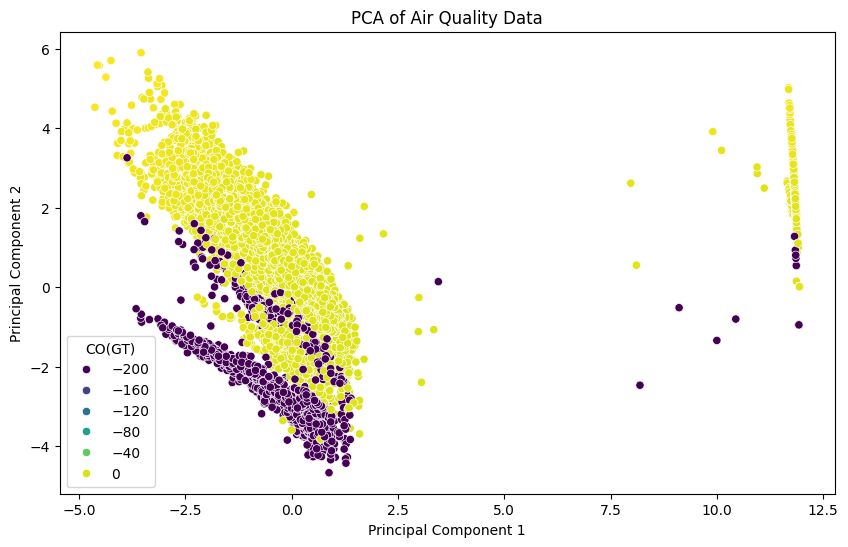

array([0.5009446 , 0.22383934])

In [15]:
from sklearn.decomposition import PCA

# 标准化数据
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_filled)

# 执行PCA，选择前两个主成分
pca = PCA(n_components=2)
principal_components = pca.fit_transform(scaled_data)

# 创建一个DataFrame来存储主成分
pca_df = pd.DataFrame(data=principal_components, columns=['Principal Component 1', 'Principal Component 2'])

# 将目标变量添加到主成分数据中
pca_df['CO(GT)'] = df_filled['CO(GT)']

# 可视化PCA结果
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Principal Component 1', y='Principal Component 2', hue='CO(GT)', data=pca_df, palette='viridis')
plt.title('PCA of Air Quality Data')
plt.show()

# 查看每个主成分所解释的方差比例
explained_variance = pca.explained_variance_ratio_
explained_variance
